In [25]:
import psycopg2 as psql
import sqlalchemy as alc
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from decouple import AutoConfig
from pathlib import Path
from importlib import reload

In [2]:
config = AutoConfig(Path('./.env'))

In [3]:
# Working on integrating Pg with Python for a more streamlined process
engine = alc.create_engine(
    f"postgresql+psycopg2://{config('DB_USER')}:{config('DB_PASS')}@{config('DB_HOST')}/{config('DB_NAME')}", 
)

In [4]:
data = pd.read_sql_table('hour', engine)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  object        
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  bool          
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  bool          
 9   weathersit  17379 non-null  object        
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

## Surface Analysis

### Correlation Map

In [5]:
corr = data.corr()
corr

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.000000,0.999995,0.404046,0.866014,0.489164,-0.004775,0.014723,0.001357,-0.003416,-0.014198,0.136178,0.137615,0.009577,-0.074505,0.158295,0.282046,0.278379
dteday,0.999995,1.000000,0.404452,0.865648,0.489808,-0.006161,0.014737,0.001372,-0.003366,-0.014063,0.136074,0.137543,0.010196,-0.074645,0.157821,0.281450,0.277753
season,0.404046,0.404452,1.000000,-0.010742,0.830386,-0.006117,-0.009585,-0.002335,0.013743,-0.014524,0.312025,0.319380,0.150625,-0.149773,0.120206,0.174226,0.178056
yr,0.866014,0.865648,-0.010742,1.000000,-0.010473,-0.003867,0.006692,-0.004485,-0.002196,-0.019157,0.040913,0.039222,-0.083546,-0.008740,0.142779,0.253684,0.250495
mnth,0.489164,0.489808,0.830386,-0.010473,1.000000,-0.005772,0.018430,0.010400,-0.003477,0.005400,0.201691,0.208096,0.164411,-0.135386,0.068457,0.122273,0.120638
hr,-0.004775,-0.006161,-0.006117,-0.003867,-0.005772,1.000000,0.000479,-0.003498,0.002285,-0.020203,0.137603,0.133750,-0.276498,0.137252,0.301202,0.374141,0.394071
holiday,0.014723,0.014737,-0.009585,0.006692,0.018430,0.000479,1.000000,-0.102088,-0.252471,-0.017036,-0.027340,-0.030973,-0.010588,0.003988,0.031564,-0.047345,-0.030927
weekday,0.001357,0.001372,-0.002335,-0.004485,0.010400,-0.003498,-0.102088,1.000000,0.035955,0.003311,-0.001795,-0.008821,-0.037158,0.011502,0.032721,0.021578,0.026900
workingday,-0.003416,-0.003366,0.013743,-0.002196,-0.003477,0.002285,-0.252471,0.035955,1.000000,0.044672,0.055390,0.054667,0.015688,-0.011830,-0.300942,0.134326,0.030284
weathersit,-0.014198,-0.014063,-0.014524,-0.019157,0.005400,-0.020203,-0.017036,0.003311,0.044672,1.000000,-0.102640,-0.105563,0.418130,0.026226,-0.152628,-0.120966,-0.142426


<AxesSubplot: >

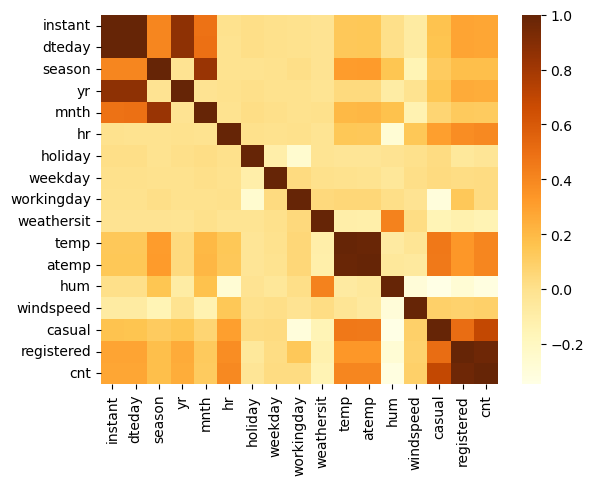

In [6]:
sns.heatmap(corr, cmap=sns.color_palette("YlOrBr", as_cmap=True))

In [7]:
cnt_corr = corr.loc['cnt', :].sort_values(ascending=False)
cnt_corr

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
dteday        0.277753
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

Looks like there exists some correlation between hour of the day and the amount of rentals. But according to rentals vs hr graph, there is correlation in behavior in users by time of day, meaning its best to group hours to remove noise: <em>morning (1), afternoon (2), evening (3), night (4)</em>.

In [8]:
st = "SELECT instant, "\
            "CASE WHEN hr < 6 THEN 4 " \
                 "WHEN hr < 12 THEN 1 " \
                 "WHEN hr < 18 THEN 2 " \
                 "ELSE 3 END day_period " \
            "FROM hour;"

In [9]:
time_pd = pd.read_sql(st, engine)

In [10]:
time_pd.head()

,instant,day_period
0,1,4
1,2,4
2,3,4
3,4,4
4,5,4


In [11]:
data = data.merge(time_pd, how='left', on='instant')
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day_period
0,1,2011-01-01,1,0,1,0,False,6,False,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,False,6,False,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,False,6,False,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,False,6,False,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,False,6,False,1,0.24,0.2879,0.75,0.0,0,1,1,4


### Categorical Features -> Dummy Vars
Correlation values are ambiguous given that some features are categorical. Breaking up into dummy variables.

In [14]:
cat_features = ['season', 'weathersit', 'weekday', 'day_period']

In [17]:
data = pd.get_dummies(data, columns=cat_features)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 33 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   instant       17379 non-null  int64         
 1   dteday        17379 non-null  datetime64[ns]
 2   yr            17379 non-null  int64         
 3   mnth          17379 non-null  int64         
 4   hr            17379 non-null  int64         
 5   holiday       17379 non-null  bool          
 6   workingday    17379 non-null  bool          
 7   temp          17379 non-null  float64       
 8   atemp         17379 non-null  float64       
 9   hum           17379 non-null  float64       
 10  windspeed     17379 non-null  float64       
 11  casual        17379 non-null  int64         
 12  registered    17379 non-null  int64         
 13  cnt           17379 non-null  int64         
 14  season_1      17379 non-null  bool          
 15  season_2      17379 non-null  bool  

In [18]:
data.head()

,instant,dteday,yr,mnth,hr,holiday,workingday,temp,atemp,hum,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,day_period_1,day_period_2,day_period_3,day_period_4
0,1,2011-01-01,0,1,0,False,False,0.24,0.2879,0.81,...,False,False,False,False,False,True,False,False,False,True
1,2,2011-01-01,0,1,1,False,False,0.22,0.2727,0.80,...,False,False,False,False,False,True,False,False,False,True
2,3,2011-01-01,0,1,2,False,False,0.22,0.2727,0.80,...,False,False,False,False,False,True,False,False,False,True
3,4,2011-01-01,0,1,3,False,False,0.24,0.2879,0.75,...,False,False,False,False,False,True,False,False,False,True
4,5,2011-01-01,0,1,4,False,False,0.24,0.2879,0.75,...,False,False,False,False,False,True,False,False,False,True


## Methods

<ul>
    <li>Will use k-fold cross validation to train/test the models. Will use $k=10$ for no other reason than it's the most common choice of k. Reason for k-fold CV is because I want to minimize variance in the model.</li>
    <li>Will be using MSE since the rentals seem to follow a general year-to-year pattern (at least as observed in years 2011, 2012) and any deviation from that is very unlikely and undesirable.</li>
</ul>

Removing features correlated with above created ones and *registered, casual* because they will only skew predictions.

In [55]:
# Ignore features correlated with the 'cnt' column being predicted
not_interest = {'casual', 'registered', 'dteday', 'mnth', 'hr', 'instant', 'cnt'}
features = set(data.columns).difference(not_interest)
features = sorted(features)
features

['atemp',
 'day_period_1',
 'day_period_2',
 'day_period_3',
 'day_period_4',
 'holiday',
 'hum',
 'season_1',
 'season_2',
 'season_3',
 'season_4',
 'temp',
 'weathersit_1',
 'weathersit_2',
 'weathersit_3',
 'weathersit_4',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'windspeed',
 'workingday',
 'yr']

## Linear Regression

Will first test the predictions of a basic linear regression model.

In [38]:
seed = 1000
rng = np.random.default_rng(seed)
rand = rng.permutation(data.shape[0])

In [50]:
k = 10
folds = [set(f) for f in np.array_split(rand, k)]
preds = []

In [66]:
train[features]

,atemp,day_period_1,day_period_2,day_period_3,day_period_4,holiday,hum,season_1,season_2,season_3,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,windspeed,workingday,yr
0,0.2879,False,False,False,True,False,0.81,True,False,False,...,False,False,False,False,False,False,True,0.0000,False,0
1,0.2727,False,False,False,True,False,0.80,True,False,False,...,False,False,False,False,False,False,True,0.0000,False,0
2,0.2727,False,False,False,True,False,0.80,True,False,False,...,False,False,False,False,False,False,True,0.0000,False,0
3,0.2879,False,False,False,True,False,0.75,True,False,False,...,False,False,False,False,False,False,True,0.0000,False,0
4,0.2879,False,False,False,True,False,0.75,True,False,False,...,False,False,False,False,False,False,True,0.0000,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17373,0.2727,False,False,True,False,False,0.48,True,False,False,...,False,True,False,False,False,False,False,0.1343,True,1
17374,0.2576,False,False,True,False,False,0.60,True,False,False,...,False,True,False,False,False,False,False,0.1642,True,1
17375,0.2576,False,False,True,False,False,0.60,True,False,False,...,False,True,False,False,False,False,False,0.1642,True,1
17376,0.2576,False,False,True,False,False,0.60,True,False,False,...,False,True,False,False,False,False,False,0.1642,True,1


In [60]:
for i, test_idx in enumerate(folds):
    # Get the training k-1 folds
    train_idx = set(data.index).difference(test_idx)
    test = data.iloc[list(test_idx), :]
    train = data.iloc[list(train_idx), :]
    
    mod = LinearRegression()
    mod.fit(train[features], train['cnt'])
    pred = mod.predict(test[features])
    
    preds.append(pred)

TypeError: Feature names are only supported if all input features have string names, but your input has ['quoted_name', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.